In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
names = open('names.txt','r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(names))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i+1:s for i,s in enumerate(chars)}
itos[0] = '.'
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [4]:
# building the dataset
context_length = 3
X, Y = [], []

for name in names[:5]:
    print(name)
    context = [0] * context_length
    for ch in name + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [7]:
X.shape

torch.Size([32, 3])

We have two equivalent ways of going from the vocabulary to the embedding space. One is to one-hot encode the word into vocabulary sized vector and then act a matrix on it to reduce to the embedding/feature vector. Or the equivalent is to just implement in the matrix and then index into it (because the one-hot encoding really is just implementing a lookup table)

In [11]:
# Mapping to a two-dimensional feature space
C = torch.randn((27,2))
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

We now want to take the three 2-dimensional feature vectors and feed it into a layer of 100 neurons. For now we implement this by thinking of concatenating the three vectors (so the input is a 6 dimensional vector) and then see how to cast the [32,3,2] to something that can multiply [6,100]

In [13]:
W1 = torch.randn([6,100])
b1 = torch.randn(100)

In [9]:
W1

tensor([[-4.3101e-01, -1.3525e+00, -7.8710e-01, -1.2069e+00,  1.0621e-01,
         -7.4190e-01, -9.9009e-02, -5.2533e-01, -9.2181e-01, -2.8947e-01,
          6.5697e-01,  6.1725e-01,  1.3430e+00, -5.6491e-01, -9.1420e-01,
         -1.2973e-01, -8.0643e-02,  2.5235e-01,  1.4371e+00, -7.1165e-01,
         -6.5689e-01,  6.9012e-01,  7.5710e-02, -6.9052e-01,  2.9509e+00,
          1.5264e+00, -3.4849e-01, -7.5348e-01, -5.4244e-01,  9.8465e-01,
          7.3840e-01, -1.9605e+00, -2.5703e-01,  1.4708e+00,  6.8091e-01,
         -7.4307e-01,  2.0809e-01, -3.5768e-01, -2.8002e-02,  2.9015e+00,
         -7.6218e-01,  5.3828e-02, -3.2856e-01,  5.8546e-04, -8.1318e-01,
          1.9539e+00,  9.0658e-01,  1.4290e-01, -5.0203e-01,  1.9928e+00,
         -4.5112e-01,  1.0846e+00, -1.1805e+00,  7.3254e-01,  9.5423e-03,
         -4.1491e-01,  3.3272e-01, -6.9578e-01, -8.1315e-01,  1.2054e+00,
         -2.2305e+00, -9.2885e-01, -1.7251e+00, -8.7128e-01,  8.0231e-01,
         -1.5751e+00, -1.3395e+00, -8.

In [21]:
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
W2 = torch.randn([100, 27])
b2 = torch.randn([27])
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)
loss = -prob[torch.arange(32), Y].log().mean()

In [22]:
# Bringing it all together 
C = torch.randn((27,2))
W1 = torch.randn([6,100])
b1 = torch.randn(100)
W2 = torch.randn([100, 27])
b2 = torch.randn([27])
parameters = [C, W1, b1, W2, b2]

In [23]:
emb = C[X]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)
loss = -prob[torch.arange(32), Y].log().mean()

In fact we can use a built in function that implements the loss calculation we are doing (because everyone uses the same loss multiple times). It is called cross_entropy

In [25]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.1916)

One very obvious but missed point to not is that probabilities are invariant under translations in logits. That makes sense because when you exponentiate, the translation because a multiplication by a common factor. Since we are normalising by the sum of the exponentials, the common factor cancels from the numerator and the denominator. And so probabilities are invariant under the translations of logits by a constant

So now we can set up the training of the network.  

In [34]:
# Hyper parameters
vocab_size = 27
embedding_space_size = 2
context_length = 3
hidden_layer_size = 100
learning_rate = -0.1

# Initialisation 
C = torch.randn((vocab_size,embedding_space_size), requires_grad=True)
W1 = torch.randn([context_length * embedding_space_size,100], requires_grad=True)
b1 = torch.randn(hidden_layer_size, requires_grad=True)
W2 = torch.randn([hidden_layer_size, vocab_size], requires_grad=True)
b2 = torch.randn([vocab_size], requires_grad=True)
parameters = [C, W1, b1, W2, b2]

for step in range(50):
    # forward pass
    emb = C[X]
    h = torch.tanh(emb.view(-1,context_length * embedding_space_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    print(f"{step = }, loss = {loss.item()}")

    # Backpropagate gradients
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    for p in parameters:
        p.data += learning_rate * p.grad

step = 0, loss = 16.99941062927246
step = 1, loss = 14.174312591552734
step = 2, loss = 12.30608081817627
step = 3, loss = 10.782776832580566
step = 4, loss = 9.624773025512695
step = 5, loss = 8.67542839050293
step = 6, loss = 7.825677871704102
step = 7, loss = 7.047819137573242
step = 8, loss = 6.323177337646484
step = 9, loss = 5.639281272888184
step = 10, loss = 4.995021820068359
step = 11, loss = 4.399930477142334
step = 12, loss = 3.8722033500671387
step = 13, loss = 3.4241044521331787
step = 14, loss = 3.04489803314209
step = 15, loss = 2.7182962894439697
step = 16, loss = 2.434873342514038
step = 17, loss = 2.187171459197998
step = 18, loss = 1.9679524898529053
step = 19, loss = 1.7717500925064087
step = 20, loss = 1.5958524942398071
step = 21, loss = 1.439687967300415
step = 22, loss = 1.3036161661148071
step = 23, loss = 1.187384843826294
step = 24, loss = 1.0892417430877686
step = 25, loss = 1.0063925981521606
step = 26, loss = 0.9358968138694763
step = 27, loss = 0.87518548

The loss here is super low because we have very few examples (only 32) and so the model is overfitting. We can now do the entire thing again but for the whole batch

In [37]:
# building the dataset
context_length = 3
X, Y = [], []

for name in names:
    context = [0] * context_length
    for ch in name + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [38]:
X.shape

torch.Size([228146, 3])

Problem is we have wayyyy too many samples, so the training is going to be slow. What we can do is to randomly select a minibatch of, let's say, 32 elements, train on them, and then the next step we again pick a random minibatch, and so on

In [44]:
# Hyper parameters
minibatch_size = 64
vocab_size = 27
embedding_space_size = 2
context_length = 3
hidden_layer_size = 100
learning_rate = -0.1

# Initialisation 
C = torch.randn((vocab_size,embedding_space_size), requires_grad=True)
W1 = torch.randn([context_length * embedding_space_size,100], requires_grad=True)
b1 = torch.randn(hidden_layer_size, requires_grad=True)
W2 = torch.randn([hidden_layer_size, vocab_size], requires_grad=True)
b2 = torch.randn([vocab_size], requires_grad=True)
parameters = [C, W1, b1, W2, b2]

for step in range(1000):
    # generate minibatch
    minibatch = torch.randint(0, X.shape[0], (minibatch_size,))

    # forward pass
    emb = C[X[minibatch]]
    h = torch.tanh(emb.view(-1,context_length * embedding_space_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[minibatch])

    # Backpropagate gradients
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    for p in parameters:
        p.data += learning_rate * p.grad
loss

tensor(2.7946, grad_fn=<NllLossBackward0>)

Now we want to understand how to track the performance of this network on the basis of the learning rate I choose. The way Andrej does it is as follows. He first creates a sample of 1000 learning rates but with exponential spacing

In [54]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [55]:
lrs

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011,
        0.0011, 0.0011, 0.0011, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012,
        0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.0013, 0.0013, 0.0013,
        0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0013, 0.0014,
        0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014, 0.0014,
        0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015,
        0.0015, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016,
        0.0016, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017,
        0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0019,
        0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0020, 0.0020,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0021, 0.0021, 0.0021, 0.0021,
        0.0021, 0.0021, 0.0021, 0.0022, 

And now we run the network for 1000 iterations, but in every iteration I go up in this list of learning rates, and I keep a track of what the loss is wrt the learning rate

In [56]:
# Hyper parameters
minibatch_size = 64
vocab_size = 27
embedding_space_size = 2
context_length = 3
hidden_layer_size = 100

lrei = []
lri = []
lossi = []

# Initialisation 
C = torch.randn((vocab_size,embedding_space_size), requires_grad=True)
W1 = torch.randn([context_length * embedding_space_size,100], requires_grad=True)
b1 = torch.randn(hidden_layer_size, requires_grad=True)
W2 = torch.randn([hidden_layer_size, vocab_size], requires_grad=True)
b2 = torch.randn([vocab_size], requires_grad=True)
parameters = [C, W1, b1, W2, b2]

for step in range(1000):
    # generate minibatch
    minibatch = torch.randint(0, X.shape[0], (minibatch_size,))

    # forward pass
    emb = C[X[minibatch]]
    h = torch.tanh(emb.view(-1,context_length * embedding_space_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y[minibatch])

    # Backpropagate gradients
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update parameters
    for p in parameters:
        p.data += -lrs[step] * p.grad
    
    # tracking stats
    lrei.append(lre[step])
    lri.append(lrs[step])
    lossi.append(loss.item())

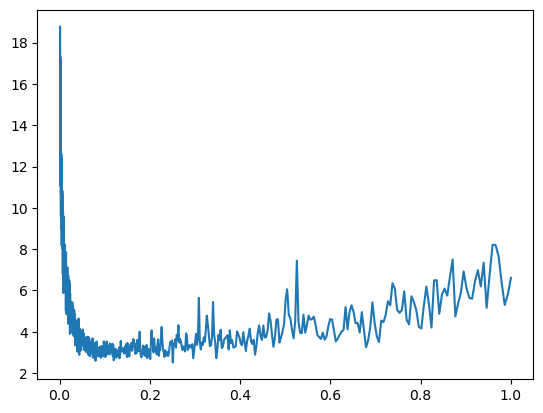

In [57]:
plt.plot(lri, lossi)

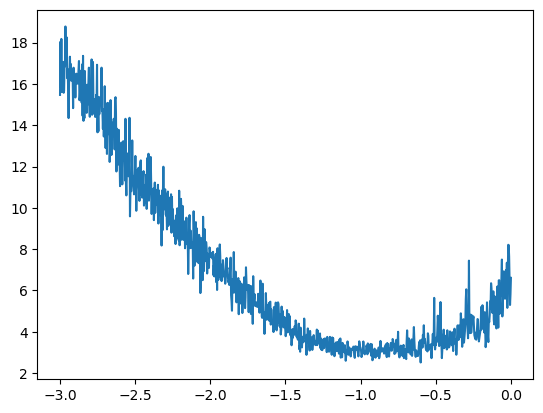

In [58]:
plt.plot(lrei,lossi)

The two things that remain are implementing train-dev-test split, implementing a learing rate decay, and sampling from the model to generate new names. This generating business was also missing from lecture 1 